# Permitted Emissions in Minneapolis (MPCA)

These are all the annual permitted emissions within Minneapolis for the years 2006 to 2020

Size: 

Source: https://www.pca.state.mn.us/air/permitted-facility-air-emissions-data

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [2]:
### Definitions

files_before = os.listdir() # Get filenames in working directory so they aren't deleted at the end.
cwd = os.getcwd() # Current Working Directory

# Forward or back slashs for filepaths? <- Not sure here. Only know Windows & Linux

if platform == "linux" or platform == "linux2":
    slash = '/'
elif platform == 'win32':
    slash = '\\'

def extract_zip_from_url(urls=None):
    '''Extract a zipfile from the internet and unpack it in working directory.
    Takes a single url (string) or a list of urls.'''
    
    if type(urls) == str: # Single url
        url = urls
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall() # Extract files
        zip_folder.close()
    
    elif type(urls) == list: # List of urls
        for url in urls:
            response = urllib.request.urlopen(url) # Get a response
            zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
            zip_folder.extractall() # Extract files
            zip_folder.close()
            
    else:
        print('Error Extracting: Invalid Input')

def clip_to_extent(gdf):
    '''This function returns the dataset clipped to the boundaries of Minneapolis and the boundary itself.
    Warning: This function will access the geojson of Minneapolis from GitHub if it's not in the current working directory or local Boundary folder.
    See this link for more info: https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb'''
    
    # Look for mpls_boundary
    
    cwd = os.getcwd() # Current working directory

    os.chdir('..') # Bump up one directory

    if 'mpls_boundary.shp' in os.listdir(cwd): # Boundary shapefile in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.shp') # Load extent as GeoDataFrame

    elif 'mpls_boundary.geojson' in os.listdir(cwd): # Boundary json in the current working directory
        mpls_boundary = gpd.read_file(r'mpls_boundary.geojson') # Load extent as GeoDataFrame

    elif 'Boundary' in os.listdir(): # Boundary folder on computer
        if 'mpls_boundary.geojson' in os.listdir('Boundary'): # Is the json there?
            path = 'Boundary' + slash + 'mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(path)

        else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame
    else:
            print('''Can't find mpls_boundary.geojson. Accessing from GitHub.\n 
            See this link for more info: \n\nhttps://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb''')
            url = 'https://raw.githubusercontent.com/RwHendrickson/MappingGZ/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.geojson'
            mpls_boundary = gpd.read_file(url) # Load extent as GeoDataFrame


    os.chdir(cwd) # Go back to current working directory
    
    if gdf.crs != 'EPSG:26915': # Ensures gdf is in the same CRS
        gdf = gdf.to_crs('EPSG:26915')
    
    clipped = gpd.clip(gdf, mpls_boundary) # Clip
    
    return clipped, mpls_boundary

In [4]:
### Load Data

## Permitted Emissions

if 'mpls_emissions.csv' not in os.listdir():
    print('''Downloading current state data from MPCA (~34 mb)\n
    It is in an excel spreadsheet so you may need to install the package: openpyxl\n
    It will take a minute or two to read.''')
    url = 'https://files.pca.state.mn.us/pub/file_requests/datasets/Air/PointSourceAirEmissionsInventory.zip'
    extract_zip_from_url(url)
    mn_emissions = pd.read_excel('PointSourceAirEmissionsInventory/MPCA_PointSourceEmissionInventory.xlsx') # Load as DataFrame

else:
    print('You already have mpls_emissions.csv. Please skip to the next notebook.')


    It is in an excel spreadsheet so you may need to install the package: openpyxl

    It will take a minute or two to read.


---

## **Select Hennepin County**

---

In [8]:
# Select for Hennepin County

print('County Names:\n')
pprint(np.sort(mn_emissions['COUNTY'].unique())) # There appears to be both HENNEPIN and Hennepin

emissions = mn_emissions[(mn_emissions['COUNTY'] == 'HENNEPIN') | (mn_emissions['COUNTY'] == 'Hennepin')]

# emissions.shape # 86033 entries

County Names:

array(['ANOKA', 'Aitkin', 'Anoka', 'BECKER', 'BENTON', 'BLUE EARTH',
       'Becker', 'Beltrami', 'Benton', 'Big Stone', 'Blue Earth', 'Brown',
       'CARVER', 'CLAY', 'CROW WING', 'Carlton', 'Carver', 'Cass',
       'Chippewa', 'Chisago', 'Clay', 'Clearwater', 'Cook', 'Cottonwood',
       'Crow Wing', 'DAKOTA', 'DOUGLAS', 'Dakota', 'Dodge', 'Douglas',
       'FREEBORN', 'Faribault', 'Fillmore', 'Freeborn', 'GOODHUE',
       'GRANT', 'Goodhue', 'Grant', 'HENNEPIN', 'Hennepin', 'Houston',
       'Hubbard', 'ITASCA', 'Isanti', 'Itasca', 'JACKSON', 'Jackson',
       'Kanabec', 'Kandiyohi', 'Kittson', 'Koochiching', 'LAKE',
       'LE SUEUR', 'Lac Qui Parle', 'Lake', 'Lake Of The Woods',
       'Le Sueur', 'Lyon', 'MCLEOD', 'MORRISON', 'MOWER', 'Mahnomen',
       'Marshall', 'Martin', 'Mcleod', 'Meeker', 'Mille Lacs', 'Morrison',
       'Mower', 'Murray', 'Nicollet', 'Nobles', 'Norman', 'Olmsted',
       'Otter Tail', 'PINE', 'PIPESTONE', 'POLK', 'PORTABLE SOURCES',
       

---

## **Lat/Lon Correction**

---

In [9]:
### NOTE: As of 3/18/2022, the LATITUDE and LONGITUDE in the downloaded file are flipped

# MPCA has been notified

print('Downloaded:\n', emissions[['LONGITUDE','LATITUDE']].head())

correct = emissions.copy(deep=True)

# Flipping Lat/Long

lats = emissions.LONGITUDE.values
lons = emissions.LATITUDE.values

correct.loc[:, 'LONGITUDE'] = lons
correct.loc[:, 'LATITUDE'] = lats

print('Corrected:\n', correct[['LONGITUDE','LATITUDE']].head())

emissions = correct

Downloaded:
     LONGITUDE  LATITUDE
15    44.9264   -93.389
16    44.9264   -93.389
17    44.9264   -93.389
18    44.9264   -93.389
19    44.9264   -93.389
Corrected:
     LONGITUDE  LATITUDE
15    -93.389   44.9264
16    -93.389   44.9264
17    -93.389   44.9264
18    -93.389   44.9264
19    -93.389   44.9264


---

## **Clean Coordinates**

---

In [10]:
### Clean Coordinates

coords = list(zip(emissions.LONGITUDE,
                  emissions.LATITUDE)) # Zip into list of coordinates stored as tuples


good_indices = [] # Store indices
bad_indices = []

for i, coord in enumerate(coords):
    if coord[0] > -93 or coord[0] < -94: # Bad Longitude
        bad_indices.append(i)
    elif coord[1] > 45.3 or coord[1] < 44.8: # Bad Latitude
        bad_indices.append(i)
    elif 'nan' in str(coord[0]) or 'nan' in str(coord[0]): # Not a number
        bad_indices.append(i)
    else:
        good_indices.append(i)
        
bad_data = emissions.iloc[bad_indices]
good_data = emissions.iloc[good_indices]

print(f"Facilities: {bad_data['FACILITY_NAME'].unique()}") # intersesting let's fix this!


Facilities: ['CS McCrossan Inc - Stationary' 'Xcel Energy - General Office'
 'Midwest Asphalt Corp - Nonmetallic'
 'Hassan Sand & Gravel Inc - Nonmetallic' 'Hardrives Inc - Nonmetallic'
 'CS McCrossan Construction Inc' 'Midwest Asphalt Corp'
 'Hassan Sand & Gravel Inc' 'Midwest Asphalt Services LLC']


In [11]:
# Find coords for companies with missing data

bad_facilities = bad_data['FACILITY_NAME'].unique()

for facility in bad_facilities:
    print(np.isin(facility, good_data['FACILITY_NAME'])) # Hmm! 
    
    # Looks like Xcel Energy's General Office has a valid location in the data, 
    # but the others do not. I'll google them sometime to see if they're in the
    # extent of this study
    
    # But Not today!

False
True
False
False
False
False
False
False
False


---

## **Spatialize**

---

In [12]:
## Spatialize

emissions_geo = gpd.GeoDataFrame(good_data, geometry=gpd.points_from_xy\
                            (good_data.LONGITUDE, good_data.LATITUDE)
                               ) # Points from xy

emissions_geo.crs = 'EPSG:4326' # Initialize CRS

emissions_geo = emissions_geo.to_crs('EPSG:26915') # Localize CRS

mpls_emissions, mpls_bound = clip_to_extent(emissions_geo) # Clip to extent

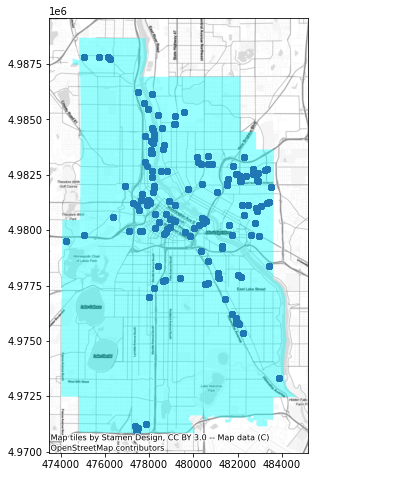

In [13]:
### Check points

f,ax = plt.subplots(1,1, figsize=(8,8))

mpls_bound.plot(ax = ax,
               cmap = 'cool',
               alpha = .4)

mpls_emissions.plot(ax = ax)


contextily.add_basemap(ax = ax, 
                       crs = mpls_bound.crs, 
                       source = contextily.providers.Stamen.TonerLite
                      )

---

## Focus & Save

---

In [14]:
# Focus the data - Note: This dataset doesn't contain pollutant groups

focus = mpls_emissions[['FACILITY_NAME', 'FACILITY_ID', 'INDUSTRY_TYPE','NAICS_CODE', 'YEAR', 
                        'POLLUTANT', 'EMISSIONS (LB)', 'EMISSIONS (TONS)']] # Select relevant columns

focus = focus.rename(columns={'EMISSIONS (LB)':'LBS_EMITTED','EMISSIONS (TONS)':'TONS_EMITTED'}) # Easier names

focus['x'] = mpls_emissions.geometry.x
focus['y'] = mpls_emissions.geometry.y

print(focus.info()) # Show column names/types/etc.
focus.head() # Look at first entries

focus.to_csv('mpls_emissions.csv', index_label='id') # Saving as 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30030 entries, 71 to 520328
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FACILITY_NAME  30030 non-null  object 
 1   FACILITY_ID    30030 non-null  int64  
 2   INDUSTRY_TYPE  30030 non-null  object 
 3   NAICS_CODE     30030 non-null  int64  
 4   YEAR           30030 non-null  int64  
 5   POLLUTANT      30030 non-null  object 
 6   LBS_EMITTED    30030 non-null  float64
 7   TONS_EMITTED   30030 non-null  float64
 8   x              30030 non-null  float64
 9   y              30030 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 2.5+ MB
None


In [ ]:
# # Careful with this cell!

# # Removes All files in working directory besides this notebook, the zipped shapefile, and all other files that were in before

# for root, dirs, files in os.walk(cwd): # Loop over files & folders
#     for file in files:
#         if file in files_before: # Keep files from before
#             pass
#         elif 'mpls_emissions.zip' == file: # Keep zip
#             pass
#         elif '.ipynb' in file: # Keep notebooks
#             pass
#         else:
#             os.remove(file) # Remove all others

---

## Exploring (Save for the next notebook)

---

In [ ]:
# ## Find unique values

# facilities_geo = focus.dissolve('Facility_ID')[['Facility','geometry']] # facilites
# years = focus['Year'].unique() # years
# # pollutant_gps = focus['Pollutant_gp'].unique() # pollutant groups <- not in new dataset

# print(pollutant_gps)
# print("\nLet's look at Criteria & Air toxic")

In [ ]:
# ## Query

# criteria = focus.loc[focus['Pollutant_gp'] == 'Criteria']
# toxics = focus.loc[focus['Pollutant_gp'] == 'Air toxic']

# ### Pollutants of interest

# crit_pollutants = criteria['Pollutant'].unique()
# toxic_pollutants = toxics['Pollutant'].unique()

# print('Criteria Pollutants', crit_pollutants) # Not too many
# # print(toxic_pollutants) # Lots! - I know the benchmarks for Benzene and Naphthalene? Part of Greater VOC Family

In [ ]:
# ## Maybe sum them up?

# # Group by Year, facility, pollutant_gp
# tox_gp = toxics.groupby(['Year','Facility_ID', 'Pollutant_gp'])

# toxic_lbs = tox_gp.sum()

# # This is where I'll stop for now

In [ ]:
# toxic_lbs